In [4]:
import tensorflow as tf

# Create a list of tf.Variables
variable_list = [tf.Variable(1.0), tf.Variable(2.0)]

# Create a new tf.Variable to be concatenated
new_variable = tf.Variable(3.0)

# Concatenate the new tf.Variable to the list
variable_list = variable_list + [new_variable]

# Now variable_list contains the concatenated list
print(variable_list)


[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>]


The choice of using the term `(learning_rate * gradients[-1])` to update the artificial viscosity in the training loop of the 1D Burgers' equation learning with Physics-Informed Neural Networks (PINNs) is based on several considerations:

1. **Connection to Gradients**: The term `gradients[-1]` represents the gradients of the loss function with respect to the last layer's biases. These gradients provide information about how changes in the biases affect the overall loss. By multiplying these gradients with the learning rate and subtracting them from the current viscosity, you are essentially making the viscosity adjust itself in the direction that reduces the loss. This is a common approach for training neural networks using gradient-based optimization methods like stochastic gradient descent (SGD) or Adam.

2. **Adaptive Learning**: This approach makes the viscosity term adaptive. Instead of keeping the viscosity fixed throughout training, you allow it to change in response to the network's performance. If the network is not accurately capturing the behavior of the Burgers' equation, the gradients will guide the viscosity towards values that improve the agreement between the network's predictions and the physics of the problem.

3. **Hyperparameter Tuning**: The `learning_rate` parameter controls the step size of the viscosity updates. By choosing an appropriate learning rate, you can control the rate at which the viscosity adapts. This allows you to balance the need for rapid convergence with the risk of overshooting or oscillations. It's a hyperparameter that you can tune to achieve better training results.

4. **Physics-Informed Learning**: In the context of Physics-Informed Neural Networks (PINNs), the goal is to approximate a physical process while satisfying the underlying equations (in this case, the Burgers' equation). The artificial viscosity is introduced to help the network satisfy these equations. By updating the viscosity based on the loss gradients, you are effectively fine-tuning the viscosity to align the network's behavior more closely with the physical laws.

5. **Experimental and Problem-Specific Choice**: The choice of how to update the viscosity is somewhat empirical and problem-specific. It's a strategy that has been found to work well in some applications, particularly when dealing with physical simulations and partial differential equations.

In summary, the choice of `(learning_rate * gradients[-1])` as the updated artificial viscosity is motivated by the desire to make the viscosity a learnable parameter that adapts during training to better match the physics of the problem. It allows the neural network to improve its predictions by adjusting this parameter based on how well it aligns with the Burgers' equation and the provided data.

Epoch 0, Loss: 0.7434002161026001
Epoch 100, Loss: 0.31031712889671326
Epoch 200, Loss: 0.3353181779384613
Epoch 300, Loss: 0.3472466468811035
Epoch 400, Loss: 0.31872323155403137
Epoch 500, Loss: 0.3784785866737366
Epoch 600, Loss: 0.4447227120399475
Epoch 700, Loss: 0.3847339451313019
Epoch 800, Loss: 0.3780477046966553
Epoch 900, Loss: 0.3573896884918213
Epoch 1000, Loss: 0.41748857498168945
Epoch 1100, Loss: 0.4196144640445709
Epoch 1200, Loss: 0.2995835244655609
Epoch 1300, Loss: 0.3549118638038635
Epoch 1400, Loss: 0.3678983151912689
Epoch 1500, Loss: 0.38692399859428406
Epoch 1600, Loss: 0.365488201379776
Epoch 1700, Loss: 0.40971481800079346
Epoch 1800, Loss: 0.33238354325294495
Epoch 1900, Loss: 0.3030496835708618
gradient component: (2, 32)
gradient component: (32,)
gradient component: (32, 32)
gradient component: (32,)
gradient component: (32, 1)
gradient component: (1,)
313/313 [==============================] - 0s 267us/step


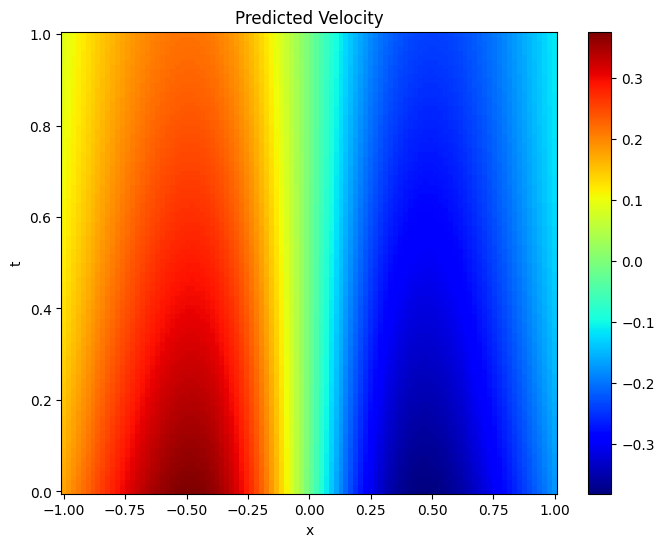

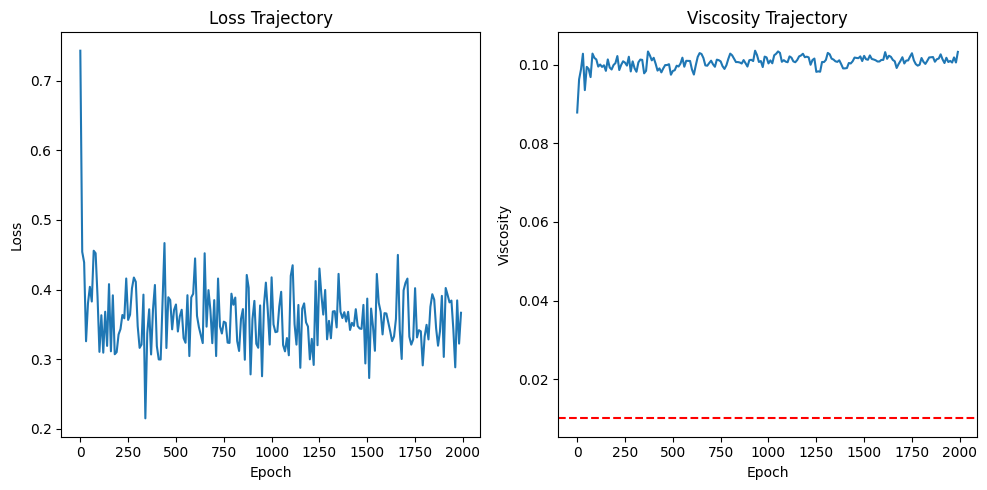

<bound method BaseResourceVariable.numpy of <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.10200322>>


In [3]:
# v7
# artificial viscosity - achieved with sub-assigning (learning_rate * gradients[-1]) 
# into updating viscosity term

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        # initial value can be tf.random.uniform(shape=(), minval=0.1, maxval=1.0)
    
# Define the initial condition
def initial_condition(domain, x):
    return -np.sin(np.pi * x)

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, collocation_points):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        # solved: not fit to tensor - changed input layer shape into (2,) for 
        # two features #
        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * tape.gradient(u_x, x)
    
    # Define the boundary and initial condition residuals
    initial_residual = u - initial_condition(domain, x)
    lower_boundary_residual = u - boundary_conditions(domain, domain.x_min, x, t)
    upper_boundary_residual = u - boundary_conditions(domain, domain.x_max, x, t)

    viscosity_loss = tf.square(domain.viscosity)  # Ground truth viscosity is 0.01

    loss = tf.reduce_mean(tf.square(residual)) + \
           tf.reduce_mean(tf.square(initial_residual)) + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) + \
            viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size, num_collocation_points):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    loss_history = []
    viscosity_history = []

    # Generate collocation points
    collocation_points_x = tf.random.uniform([num_collocation_points, 1], minval=domain.x_min, maxval=domain.x_max)
    collocation_points_t = tf.random.uniform([num_collocation_points, 1], minval=domain.t_min, maxval=domain.t_max)
    collocation_points = tf.concat([collocation_points_x, collocation_points_t], axis=1)

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, collocation_points)

        gradients = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        # try#1 Update the viscosity value during training
        # domain.viscosity.assign(network.layers[-1].weights[0].numpy())

        # try#2
        # Manually update the trainable_viscosity variable based on gradients
        viscosity_update = tf.reduce_sum(learning_rate * gradients[-1])
        # print("shape of nu:", domain.viscosity)
        # print("update.numpy:", viscosity_update.shape)
        domain.viscosity.assign_sub(viscosity_update)  # Update the last gradient element

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            loss_history.append(loss.numpy())
            viscosity_history.append(domain.viscosity.numpy())
    
    # check gradient
    for grad in gradients:
        print("gradient component:", grad.shape)
    # print("gradient component:", gradients)
    return network, loss_history, viscosity_history 
# worked after changing it to "network"???
#TODO: showed me the NameError before: NameError                        Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain, loss_history, viscosity_history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, np.newaxis], t_grid.flatten()[:, np.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, viscosity_history)
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 100
    num_t = 100
    viscosity_init_v = 0.1
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v)
    num_epochs = 2000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, loss_history, viscosity_history = train_model(network, 
                                                         domain, 
                                                         num_epochs, 
                                                         learning_rate=0.01, 
                                                         batch_size=32, 
                                                         num_collocation_points=1000
                                                         )

    # Visualize the results
    visualize_results(model, domain, loss_history, viscosity_history, num_epochs)

    print(domain.viscosity.numpy)
